In [1]:
import sys
sys.path.insert(0, './../')

import os
import utils_modelling as utils

In [2]:
path_dataset = "./../../../dataset_used_split_aug"
path_test = os.path.join(path_dataset, "test")
test_img, test_mask = utils.load_img_mask(path_test)
testset = utils.create_dataset(test_img, test_mask)

In [3]:
predicted_mask, model = utils.predict_model(testset, file_name="unet_model_aug", batches=8, get_one=False)

1/1 [==============================] - 1s 870ms/step


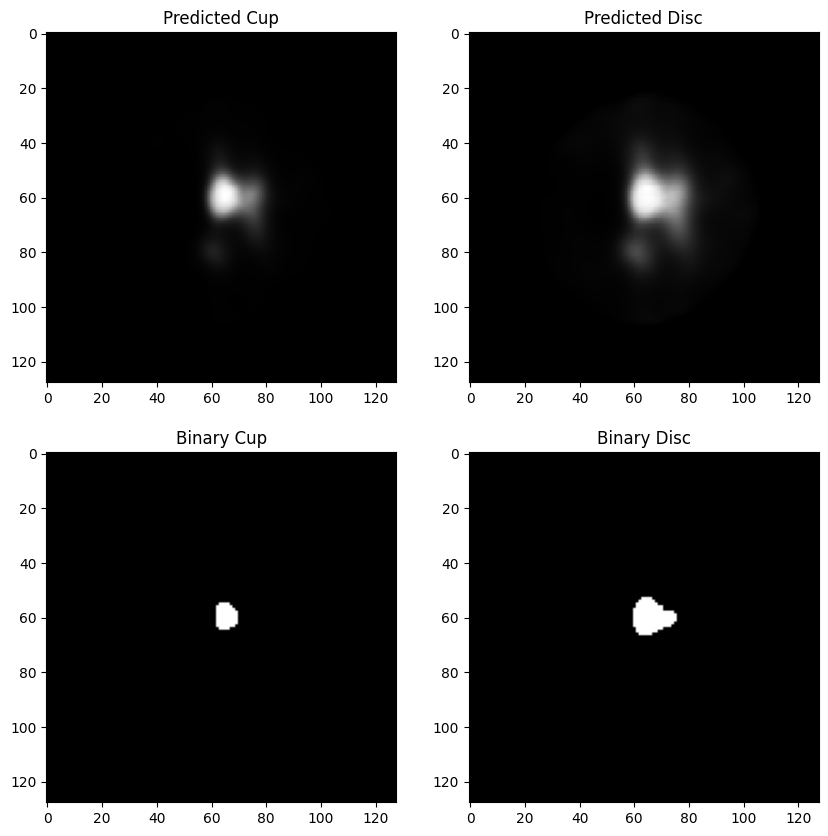

In [64]:
cup_mask, disc_mask, bcup_mask, bdisc_mask = utils.split_disc_cup_mask(predicted_mask, treshold=.2, img_idx=13)

In [52]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [51]:
np.unique(bcup_mask[0])

array([0, 1])

In [65]:
bcup_mask.shape

TensorShape([16, 128, 128])

Mask shape:  (128, 128, 1)
[0 1 2]


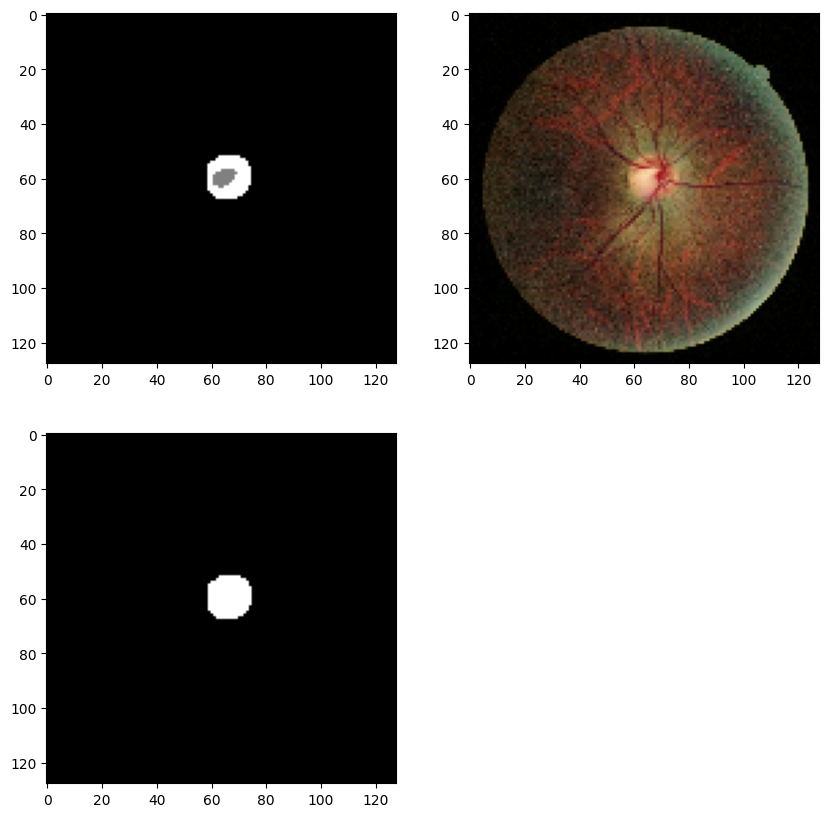

In [55]:
for image, mask in testset.take(1):
    # update_mask = tf.where(mask == 2, 0, mask)
    update_mask = tf.where(mask == 2, 1, mask)
    
    idx=13
    print("Mask shape: ", mask[idx].shape)
    print(np.unique(mask[idx]))
    plt.figure(figsize=(10, 10))
    plt.subplot(2,2, 1)
    plt.imshow(mask[idx], cmap="gray")
    plt.subplot(2,2, 2)
    plt.imshow(image[idx])
    plt.subplot(2,2, 3)
    plt.imshow(update_mask[idx], cmap="gray")

Metrics:
- IoU = tp / (tp +fp + fn)
- Dice Score
- Precision
- Recal